

# Data Loading



In [ ]:
from more_itertools import unzip
from torch.utils.data import DataLoader, Dataset, random_split
import kaggle
import zipfile
import pandas as pd
import os
from PIL import Image
from yaml import load
from torchvision import transforms
import pandas as pd
import numpy as np
import torch

class HistopathologicCancerDetectionDataset(Dataset):
    KAGGLE_DATASET = "histopathologic-cancer-detection"

    def __init__(self, data_path,figsize=224):
        self.data_path = data_path
        self._download()
        self.train_labels = pd.read_csv(
            os.path.join(self.data_path, "train_labels.csv")
        )
        self.transforms = transforms.Compose([transforms.Resize(figsize),
                                              transforms.ToTensor()],
                                             )
        *(
                [
                    transforms.RandomApply(
                        [
                            transforms.ColorJitter(brightness=0.5),
                            transforms.ColorJitter(contrast=0.5),
                            transforms.ColorJitter(saturation=0.5),
                            transforms.ColorJitter(hue=0.5),
                        ],
                        0.5,
                    )
                ]
            ),
            *(
                [
                    transforms.RandomApply(
                        [
                            transforms.RandomRotation((0, 0)),
                            transforms.RandomHorizontalFlip(p=1),
                            transforms.RandomVerticalFlip(p=1),
                            transforms.RandomRotation((90, 90)),
                            transforms.RandomRotation((180, 180)),
                            transforms.RandomRotation((270, 270)),
                        ],
                        0.5,
                    )
                ]
            ),
                                              

    def __len__(self):
        return len(self.train_labels)

    def __getitem__(self, index):
        image_id = self.train_labels["id"].iloc[index]
        label = self.train_labels["label"].iloc[index]
        img = Image.open(os.path.join(self.data_path, "train", image_id + ".tif"))
        return self.transforms(img), label

    def _download(self):
        kaggle.api.authenticate()
        kaggle.api.competition_download_files(
            self.KAGGLE_DATASET, path=self.data_path, quiet=False
        )
        # Only unzip if we cannot find certain files
        if not set(["train", "train_labels.csv"]).issubset(os.listdir(self.data_path)):
            with zipfile.ZipFile(
                os.path.join(self.data_path, self.KAGGLE_DATASET + ".zip")
            ) as zipped:
                zipped.extractall(self.data_path)


def load_data(data_path=None,figsize=224 ,test_split=0.33, batch_size=32):
    """
    Downloads the dataset from Kaggle if needed, creates a Pytorch Dataset and then
    setups data loaders for the training and test set.

    Required setup:
    1. Go to https://www.kaggle.com/<ACCOUNT_NAME>/account
    2. Click "Create New API Token"
    3. Add Token file to ~/.kaggle/kaggle.json
    """
    if not data_path:
        data_path = os.path.join(os.path.dirname(os.path.realpath(__file__)), "data")
    dataset = HistopathologicCancerDetectionDataset(data_path,figsize)
    test_size = int(len(dataset) * test_split)
    train_size = len(dataset) - test_size
    train_set, test_set = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
    test_loader = DataLoader(test_set, batch_size=batch_size)
    return train_loader, test_loader

Train Model Code

In [ ]:
def train_model(model, criterion, optimizer, scheduler,train_loader,val_loader, num_epochs=25):
    '''
    Function to train the model 
    '''
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                loader=train_loader# Set model to training mode and choose the correct dataloader
            else:
                model.eval() 
                loader=val_loader# Set model to evaluate mode and choose the correct dataloader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for s in loader:
                #To(device) transfers the image is on the GPU
                inputs = s[0].to(device)#zeros element here refers to image
                
                #casting labels to long as float doesn't work to train the resnet
                
                labels = (s[1]).type(torch.LongTensor)# first element is the label
                labels = labels.to(device)
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(loader)
            if(phase== 'train'):
                _,cf_matrix,_=evaluate_model(model,train_loader)
                tn, fp, fn, tp = cf_matrix.ravel()
                specificity=tn/(tn+fp)
                sensitivity=tp/(tp+fn)
                precision=tp/(tp+fp)
                epoch_acc=(tp + tn) / (tp + fn + fp + tn)
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                print('train Sensitivity is {}'.format(sensitivity))
                print()
                print('train specificity is {}'.format(specificity))
                print()
                print('train precision is {}'.format(precision))
                print()
                print('Confusion matrix {}'.format(cf_matrix))
                metrics={"train_loss": epoch_loss, 
                         "train_accuracy":epoch_acc,
                        "train_Sensitivity ": sensitivity,
                        "train_precision ":precision,
                        "train_specificity ":(specificity),
                         
                        }
                
                
            else:
                _,cf_matrix,_=evaluate_model(model,val_loader)
                tn, fp, fn, tp = cf_matrix.ravel()
                specificity=tn/(tn+fp)
                sensitivity=tp/(tp+fn)
                precision=tp/(tp+fp)
                epoch_acc=(tp + tn) / (tp + fn + fp + tn)
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                print('val Sensitivity is {}'.format(sensitivity))
                print()
                print('val specificity is {}'.format(specificity))
                print()
                print(' val precision is {}'.format(precision))
                print()

                print()
                print('Confusion matrix {}'.format(cf_matrix))
                metrics={"val_loss": epoch_loss, 
                         "val_accuracy":epoch_acc,
                        "val_Sensitivity ": sensitivity,
                        "val_precision ":precision,
                        "val_specificity ":(specificity),
                         
                        }
                
            #wandb.log({**metrics})
            #Calculate classification metrics

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model,test_loader,num_images=6):
    '''
    Function to visualize the output of the model
    '''
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, s in enumerate(test_loader):
            inputs = s[0].to(device)
            #concat the input to change to 3 channels
            #casting labels to long as float doesn't work to train the resnet
            labels = (s[1]).type(torch.LongTensor)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
           

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {preds[j]} True label: {labels[j]}')
                #spliting x to visualize output to undo concat
                x=torch.split(inputs.cpu().data[j],3, dim=0)[0][0]
                plt.imshow(x)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
def evaluate_model(model,val_loader):
    '''
    Method to check the model preformance per different classification metrics and get predicated probability back 
    '''
    was_training = model.training
    model.eval()
    y_pred = []
    y_prob = []
    y_true = []
    CM=0
    with torch.no_grad():
        for i, s in enumerate(val_loader):
            inputs = s['image'].to(device)

            #casting labels to long as float doesn't work to train the resnet
            labels = (s['CDGLOBAL']).type(torch.LongTensor)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.data.cpu().numpy())

            prob = torch.sigmoid(outputs)[:,1] #Get class1 probabilities
            y_prob.extend(prob.data.cpu().numpy())
            y_true.extend(labels.data.cpu().numpy())
            
    cf_matrix = confusion_matrix(y_true, y_pred)   
    return y_true ,cf_matrix, y_prob



> Creating Dataset and initliasing GPU





In [ ]:
#Code checks for gpu and if so sets device to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#Check that gpu is avaiable should print True
torch.cuda.is_available()

True

In [ ]:
#Creates dataset instance,train and test loaders
train=HistopathologicCancerDetectionDataset(data_path='.')
train_loader, test_loader=load_data(data_path='.',figsize=224,batch_size=32)

100%|██████████| 6.31G/6.31G [01:48<00:00, 62.7MB/s]



histopathologic-cancer-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


Visualisation of one image to make sure data is loaded correctly 

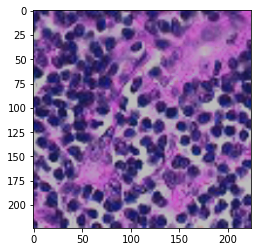

In [ ]:
import matplotlib.pyplot as plt
s=(next(iter(train_loader))[0])#First element in dataloader is the image
plt.imshow(s[0, :,:,:].permute(1, 2, 0)); #data loader returns 4d tensor with incorrect order of RGB 

# Model and training 

### Resnet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix
lr=0.001 
c=0.9
step_size=7 
gamma=0.1
epochs=10
batch_size=32
cudnn.benchmark = True
model_resnet = models.resnet18(pretrained=True)#choosing the model
num_ftrs = model_resnet.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_resnet.fc = nn.Linear(num_ftrs, 2)

model_resnet = model_resnet.to(device)#To train on GPU
criterion = nn.CrossEntropyLoss()#Defined cross entropy loss

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_resnet.parameters(), lr=lr, momentum=momentum)#choose which parameters to optimize and hyperparameters

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=step_size, gamma=gamma)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
#Actual resnet model training
model_resnet = train_model(model_resnet, criterion, optimizer_ft, exp_lr_scheduler,train_loader, test_loader,num_epochs=10)

Epoch 0/9
----------
train Loss: 8.9578 Acc: 0.9250
train Sensitivity is 0.8795821175839287

train specificity is 0.9558228814235102

train precision is 0.9311569118247501

Confusion matrix [[83905  3878]
 [ 7181 52453]]
val Loss: 6.4701 Acc: 0.9233
val Sensitivity is 0.8765390224875352

val specificity is 0.9552231884057971

 val precision is 0.9304745445380572


Confusion matrix [[41194  1931]
 [ 3640 25843]]

Epoch 1/9
----------
train Loss: 6.8466 Acc: 0.9347
train Sensitivity is 0.8794982727973975

train specificity is 0.9722725356845858

train precision is 0.9556503042892023

Confusion matrix [[85349  2434]
 [ 7186 52448]]


In [ ]:
visualize_model(model_resnet,test_loader,num_images=12)

In [ ]:
#save model
torch.save(model_resnet.state_dict(), 'model_resnet_augmented')



> VGG

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix
cudnn.benchmark = True
model_vgg16 = models.vgg16(pretrained=True)#choosing the model

num_features = model_vgg16.classifier[6].in_features
features = list(model_vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, 2)]) # Add our layer with 4 outputs
model_vgg16.classifier = nn.Sequential(*features)
model_vgg16 = model_vgg16.to(device)#To train on GPU
criterion = nn.CrossEntropyLoss()#Defined cross entropy loss

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_vgg16.parameters(), lr=0.001, momentum=0.9)#choose which parameters to optimize and hyperparameters

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
print(model_vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model_vgg16 = train_model(model_vgg16, criterion, optimizer_ft, exp_lr_scheduler,train_loader, test_loader,num_epochs=5)

Epoch 0/4
----------


In [ ]:
torch.save(model_resnet.state_dict(), 'model_vgg_5epochs')

NameError: ignored

In [ ]:


#Create test loader 
class HistopathologicCancerDetectionDataset_test(Dataset):
    KAGGLE_DATASET = "histopathologic-cancer-detection"

    def __init__(self, data_path,figsize=224):
        self.data_path = data_path
        self.test_id = pd.read_csv(
            os.path.join(self.data_path, "sample_submission.csv")
        )
        self.transforms = transforms.Compose([transforms.Resize(figsize),
                                              transforms.ToTensor()],
                                             )

    def __len__(self):
        return len(self.test_id)

    def __getitem__(self, index):
        image_id = self.test_id["id"].iloc[index]
        img = Image.open(os.path.join(self.data_path, "test", image_id + ".tif"))
        return self.transforms(img), image_id

    


test=HistopathologicCancerDetectionDataset_test('.')
test_loader=DataLoader(test)

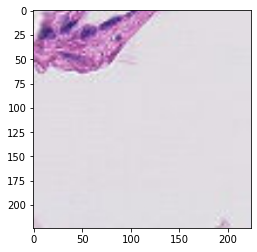

In [ ]:
import matplotlib.pyplot as plt
s=(next(iter(test_loader))[0])#First element in dataloader is the image
plt.imshow(s[0, :,:,:].permute(1, 2, 0));

Submission to kaggle

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load('model_resnet'))
model = model.to(device)
model.eval()
import csv
f = open('results.csv', 'w')
writer = csv.writer(f)

header = ['id', 'label']
writer.writerow(header)
with torch.no_grad():
        for i, s in enumerate(test_loader):
            inputs = s[0].to(device)
            
            #casting labels to long as float doesn't work to train the resnet
            id = (s[1][0])
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            prob = torch.sigmoid(outputs)[:,1]
            row=[id,prob.item()]

            
            writer.writerow(row)


In [ ]:
f.close()

In [ ]:
next(iter(test_loader))[1][0]

'0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5'

In [ ]:
!kaggle competitions submit histopathologic-cancer-detection -f results.csv -m "resnet_5_epochs"

100% 3.40M/3.40M [00:02<00:00, 1.27MB/s]
Successfully submitted to Histopathologic Cancer Detection